# **Walmart Project : Weekly Sales Prediction with Linear Models**

Link to Google Collab notebook: https://colab.research.google.com/drive/1pkOd0fQmOiZsRZ_3TH-XpG8MKBYnF3__?usp=sharing

### Imports

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Import dataset

df = pd.read_csv('Walmart_Store_sales.csv')


# Part 1. EDA

#### Basic statistics

In [ ]:
# Show basic stats

print("Number of rows : {}".format(df.shape[0]))
print("Number of columns : {}".format(df.shape[1]))
print()

print("Basics statistics: ")
data_desc = df.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*df.isnull().sum()/df.shape[0])

display(df.info())

Number of rows : 150
Number of columns : 8

Basics statistics: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000



Percentage of missing values: 


,0
Store,0.000000
Date,12.000000
Weekly_Sales,9.333333
Holiday_Flag,8.000000
Temperature,12.000000
Fuel_Price,9.333333
CPI,8.000000
Unemployment,10.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         150 non-null    float64
 1   Date          132 non-null    object 
 2   Weekly_Sales  136 non-null    float64
 3   Holiday_Flag  138 non-null    float64
 4   Temperature   132 non-null    float64
 5   Fuel_Price    136 non-null    float64
 6   CPI           138 non-null    float64
 7   Unemployment  135 non-null    float64
dtypes: float64(7), object(1)
memory usage: 9.5+ KB


None

In [ ]:
display(df.head())

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


**Description of the raw dataset:**

*   The dataset contains 150 observations and 8 variables
*   The date variable needs to be formatted consistently as a single date type as it contains two different types of date formats
*   Most variables have around 8-12% of missing values, except for Store which does not have any.



### Average Weekly Sales over Time

In [ ]:
df['Date'] = pd.to_datetime(df['Date']) # Convert date variable to datetime format

weekly_avg = df.groupby('Date')['Weekly_Sales'].mean().reset_index()

fig = px.line(weekly_avg, x='Date', y='Weekly_Sales',
              title='Average Weekly Sales Over Time')

fig.update_traces(line=dict(color="royalblue", width=2))
fig.update_layout(
    xaxis=dict(
        title="Date",
        tickangle=45,
        tickformatstops=[
            dict(dtickrange=[None, "M1"], value="%b %Y")
        ],
        dtick="M3"  # tick every 3 months
    ),
    yaxis=dict(title="Avg Weekly Sales", tickformat=","),
    template="plotly_white",
    title_x=0.5
)

fig.show()


/tmp/ipython-input-3017507001.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date']) # Convert date variable to datetime format


**Observations:**

- The most prominent peaks in average weekly sales occur around the winter holidays right before Christmas, specfically.
- Low sales occur around May or Oct-early november and pick right up during Black friday sales (late november/Thanksgiving)

## Weekly Sales by Holiday flag

In [ ]:
# Boxplot
fig_box = px.box(
    df,
    x="Holiday_Flag", y="Weekly_Sales",
    title="Weekly Sales by Holiday Flag",
    labels={"Holiday_Flag": "Holiday (1=Yes, 0=No)", "Weekly_Sales": "Weekly Sales"},
    points="all"
)
fig_box.update_layout(template="plotly_white", title_x=0.5)
fig_box.show()

# Alternative: Violin plot (shows density)
fig_violin = px.violin(
    df,
    x="Holiday_Flag", y="Weekly_Sales",
    box=True, points="all",
    title="Weekly Sales by Holiday Flag",
    labels={"Holiday_Flag": "Holiday (1=Yes, 0=No)", "Weekly_Sales": "Weekly Sales"}
)
fig_violin.update_layout(template="plotly_white", title_x=0.5)
fig_violin.show()


**Observations:**

- Median sales are slightly higher during holidays compared to non-holidays.

-> Holidays: median = 1.6M

-> Non-holidays: median = 1.2M

- This suggests that holidays bring a slight boost in sales.

## Average Weekly Sales over Time by Store

In [ ]:
# Compute average sales per store (all stores, sorted)
store_sales = (
    df.groupby("Store")["Weekly_Sales"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

# Plot all stores (20 bars if 20 stores exist)
fig_bar = px.bar(
    store_sales,
    x="Store", y="Weekly_Sales",
    title="Average Weekly Sales by Store",
    labels={"Weekly_Sales": "Avg Weekly Sales"},
    text_auto=".2s"
)

fig_bar.update_layout(
    template="plotly_white",
    title_x=0.5,
    xaxis=dict(tickmode="linear", dtick=1, title="Store"),
    yaxis=dict(title="Avg Weekly Sales", tickformat=",")
)

fig_bar.show()


**Observations:**

- Some stores appear to be doing better than others throughout the time period: stores 4, 14, 13, 20


## Pairwise dependencies

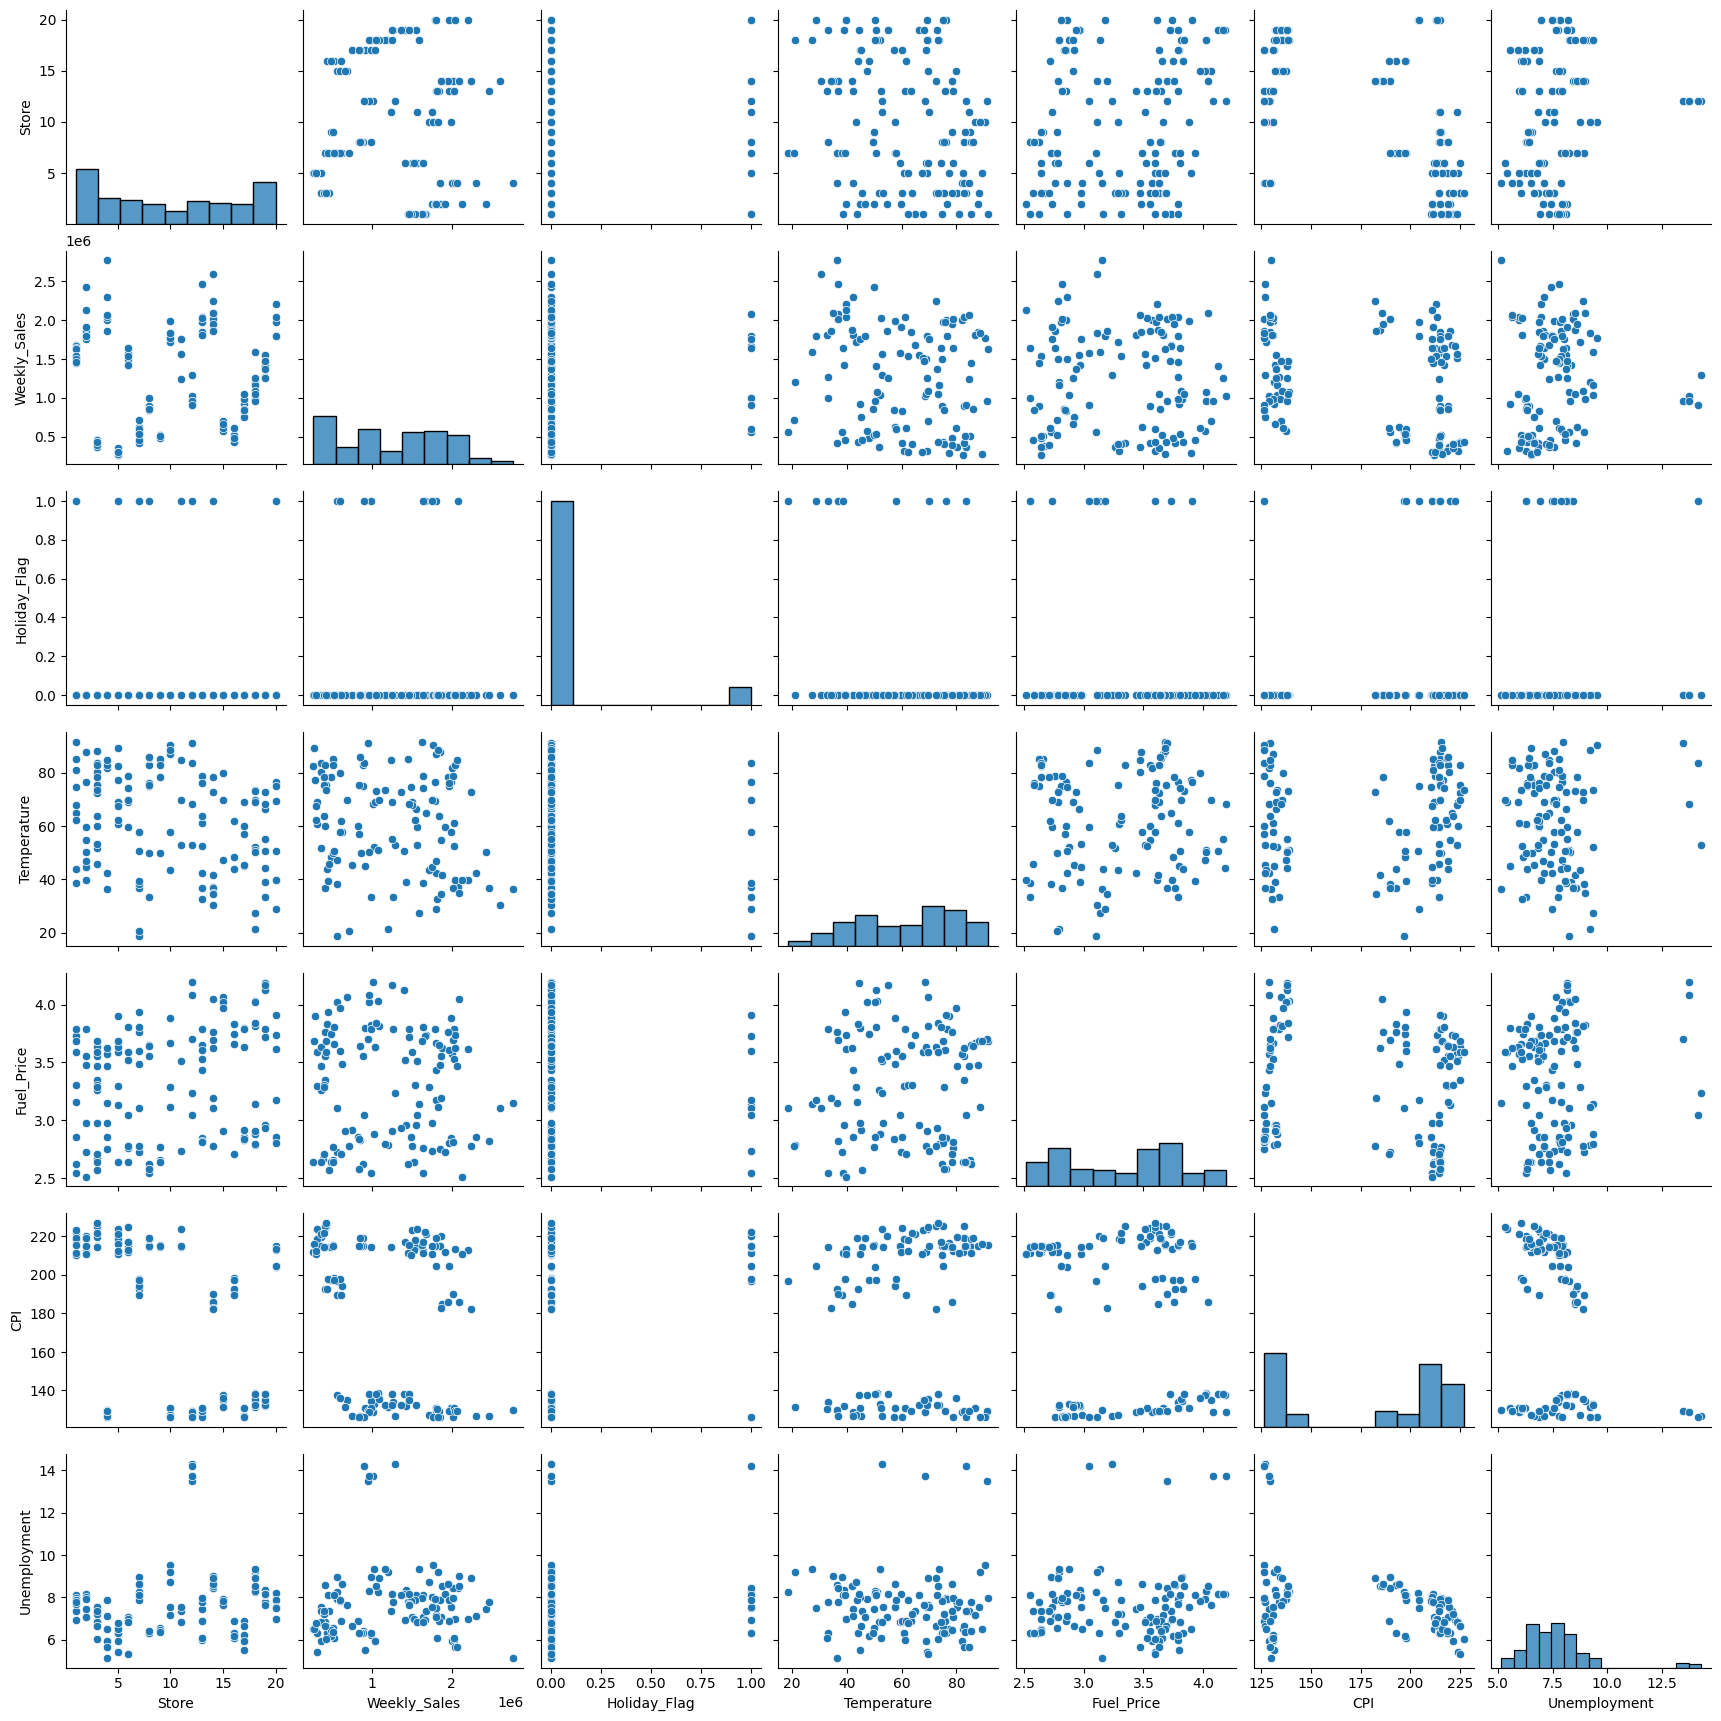

In [ ]:
# Visualize pairwise dependencies
sns.pairplot(df)

## Correlation Heatmap

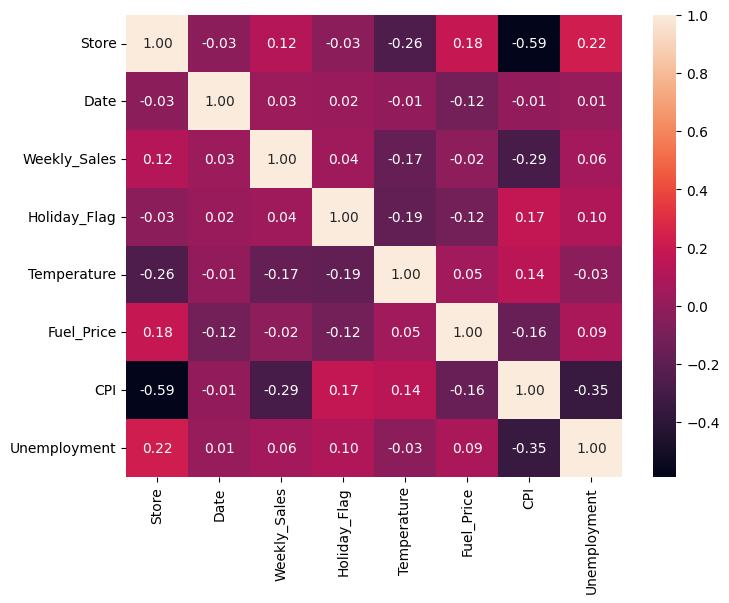

In [ ]:
# Check Correlation
df_corr = df.corr().round(2)

# Viz
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.show()

**Observations:**

*   Based on the pairwise scatterplot, we can notice a potential linear relationship between unemployment level and weekly sales. Relationships with the remaining variables are hard to tell from the scatter plots.
- The unemployment feature contains some outliers.
*   As illustrated by the correlation heatmap,  CPI (-0.29), temperature (-0.17)and  store number (0.12) have the highest correlation level with the target.

# Part 2. Preprocessing

### Missing values handling

In [ ]:
# Drop observations where target and date values are missing

df = df[~df['Weekly_Sales'].isnull()]
df = df[~df['Date'].isnull()]

df.shape

(118, 8)

In [ ]:
# Fill in the holiday flag where missing (based on date)

from pandas.tseries.holiday import USFederalHolidayCalendar

calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=df['Date'].min(), end=df['Date'].max())

df['Holiday_Flag'] = df['Date'].isin(holidays).astype(int)

missing_mask = df['Holiday_Flag'].isna()
df.loc[missing_mask, 'Holiday_Flag'] = df.loc[missing_mask, 'Date'].isin(holidays).astype(int)


In [ ]:
display(df.describe(include="all"))

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,118.000000,118,1.180000e+02,118.000000,107.000000,107.000000,109.000000,107.000000
mean,9.949153,2011-04-23 04:28:28.474576384,1.257271e+06,0.016949,60.711589,3.291542,177.718009,7.681299
min,1.000000,2010-02-05 00:00:00,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.250000,2010-07-30 00:00:00,5.774276e+05,0.000000,45.465000,2.824000,131.637000,6.664000
50%,9.000000,2011-04-29 00:00:00,1.331001e+06,0.000000,61.790000,3.308000,194.379637,7.484000
75%,15.000000,2011-12-31 18:00:00,1.810591e+06,0.000000,75.430000,3.691500,214.777523,8.150000
max,20.000000,2012-10-19 00:00:00,2.771397e+06,1.000000,91.650000,4.193000,226.968844,14.313000
std,6.066367,NaN,6.625056e+05,0.129631,17.961676,0.486784,39.816657,1.678155


### Outliers handling

In [ ]:
# Drop rows with outliers beyond 3 standard deviations for 'Unemployment'

lower_bound = df["Unemployment"].mean() - 3 * df["Unemployment"].std()
upper_bound = df["Unemployment"].mean() + 3 * df["Unemployment"].std()

# Remove outliers with masks
df = df.drop(df.loc[(df["Unemployment"] <= lower_bound) | (df["Unemployment"] >= upper_bound)].index)

### Feature Engineering

In [ ]:
# Create usable features from the Date column: year, month, day, day of week

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Quarter'] = df['Date'].dt.quarter

display(df.head())
display(df.describe(include="all"))

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,Quarter
0,6.0,2011-02-18,1572117.54,0,59.61,3.045,214.777523,6.858,2011,2,18,1
1,13.0,2011-03-25,1807545.43,0,42.38,3.435,128.616064,7.470,2011,3,25,1
4,6.0,2010-05-28,1644470.66,0,78.89,2.759,212.412888,7.092,2010,5,28,2
5,4.0,2010-05-28,1857533.70,0,NaN,2.756,126.160226,7.896,2010,5,28,2
6,15.0,2011-06-03,695396.19,0,69.80,4.069,134.855161,7.658,2011,6,3,2


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,Quarter
count,113.000000,113,1.130000e+02,113.000000,103.000000,102.000000,104.000000,102.000000,113.000000,113.000000,113.000000,113.000000
mean,9.858407,2011-04-24 21:52:33.982300928,1.267415e+06,0.017699,60.197087,3.273863,180.105389,7.376775,2010.831858,6.274336,16.530973,2.415929
min,1.000000,2010-02-05 00:00:00,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000,2010.000000,1.000000,1.000000,1.000000
25%,4.000000,2010-07-30 00:00:00,5.634608e+05,0.000000,45.020000,2.814750,132.579257,6.642250,2010.000000,4.000000,10.000000,2.000000
50%,9.000000,2011-04-22 00:00:00,1.420405e+06,0.000000,61.110000,3.302500,197.500965,7.404500,2011.000000,6.000000,17.000000,2.000000
75%,15.000000,2012-01-13 00:00:00,1.847431e+06,0.000000,75.255000,3.683500,214.809008,8.096750,2012.000000,9.000000,24.000000,3.000000
max,20.000000,2012-10-19 00:00:00,2.771397e+06,1.000000,91.650000,4.170000,226.968844,9.524000,2012.000000,12.000000,31.000000,4.000000
std,6.184467,NaN,6.746824e+05,0.132443,17.878511,0.481421,39.201866,0.973078,0.822699,3.179869,8.238705,1.066751


In [ ]:
# Transform Day and Month into cyclical features to capture periodic patterns:

df["Day_sin"] = np.sin(2 * np.pi * df["Day"] / 31)
df["Day_cos"] = np.cos(2 * np.pi * df["Day"] / 31)

df["Month_sin"] = np.sin(2 * np.pi * df["Month"] / 12)
df["Month_cos"] = np.cos(2 * np.pi * df["Month"] / 12)

#df.drop(columns=["Day", "Month"], inplace=True)
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,Quarter,Day_sin,Day_cos,Month_sin,Month_cos
0,6.0,2011-02-18,1572117.54,0,59.61,3.045,214.777523,6.858,2011,2,18,1,-0.485302,-0.874347,8.660254e-01,5.000000e-01
1,13.0,2011-03-25,1807545.43,0,42.38,3.435,128.616064,7.470,2011,3,25,1,-0.937752,0.347305,1.000000e+00,6.123234e-17
4,6.0,2010-05-28,1644470.66,0,78.89,2.759,212.412888,7.092,2010,5,28,2,-0.571268,0.820763,5.000000e-01,-8.660254e-01
5,4.0,2010-05-28,1857533.70,0,NaN,2.756,126.160226,7.896,2010,5,28,2,-0.571268,0.820763,5.000000e-01,-8.660254e-01
6,15.0,2011-06-03,695396.19,0,69.80,4.069,134.855161,7.658,2011,6,3,2,0.571268,0.820763,1.224647e-16,-1.000000e+00


### ML Preprocessing

In [ ]:
# Convert 'Store' and 'Holiday_Flag' as object type to consider them as categoric features in the model (vs numeric)

df['Store'] = df['Store'].astype(object)
df['Holiday_Flag'] = df['Holiday_Flag'].astype(object)

In [ ]:
# Separate X and Y

target = 'Weekly_Sales'
X = df.drop(target, axis=1)
y = df[target]

In [ ]:
# Train, test split on time since this is a temporal dataset

df = df.sort_values("Date") #sort dataframe by Date

cut_date = df["Date"].quantile(0.8)   # last 20% of dates

train_mask = df["Date"] <= cut_date
test_mask  = df["Date"] > cut_date

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

/tmp/ipython-input-1683481812.py:10: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipython-input-1683481812.py:10: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



Sanity check

In [ ]:
X_train.describe()

,Date,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,Quarter,Day_sin,Day_cos,Month_sin,Month_cos
count,90,82.000000,79.000000,81.000000,80.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,9.000000e+01,90.000000
mean,2011-01-08 11:28:00,60.472317,3.130797,181.391579,7.446450,2010.533333,6.355556,16.711111,2.444444,-0.025110,-0.095768,2.182335e-02,-0.122913
min,2010-02-05 00:00:00,18.790000,2.514000,126.111903,5.143000,2010.000000,1.000000,1.000000,1.000000,-0.998717,-0.994869,-1.000000e+00,-1.000000
25%,2010-06-25 00:00:00,42.385000,2.765000,132.521867,6.816750,2010.000000,4.000000,10.000000,2.000000,-0.706438,-0.758758,-5.000000e-01,-0.866025
50%,2010-12-10 00:00:00,62.985000,2.963000,204.567546,7.455500,2010.000000,6.000000,17.000000,2.000000,-0.151233,-0.250653,1.224647e-16,-0.500000
75%,2011-07-20 06:00:00,76.242500,3.562000,214.777523,8.099000,2011.000000,8.000000,25.000000,3.000000,0.651372,0.528964,5.000000e-01,0.500000
max,2012-02-17 00:00:00,91.650000,4.069000,221.643285,9.524000,2012.000000,12.000000,31.000000,4.000000,0.998717,1.000000,1.000000e+00,1.000000
std,NaN,19.035223,0.442534,38.808584,0.962615,0.639522,3.275071,8.338680,1.061175,0.708833,0.706314,6.679428e-01,0.741168


In [ ]:
X_test.describe()

,Date,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,Quarter,Day_sin,Day_cos,Month_sin,Month_cos
count,23,21.000000,23.000000,23.000000,22.000000,23.0,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,2.300000e+01
mean,2012-06-14 09:23:28.695652096,59.122381,3.765261,175.575766,7.123409,2012.0,5.956522,15.826087,2.304348,-0.129917,-0.209424,0.136260,-2.158305e-01
min,2012-02-24 00:00:00,39.300000,3.346000,130.645793,5.422000,2012.0,2.000000,1.000000,1.000000,-0.988468,-0.994869,-1.000000,-1.000000e+00
25%,2012-04-09 12:00:00,50.600000,3.595000,137.753727,6.118500,2012.0,3.500000,11.500000,1.500000,-0.757784,-0.758758,-0.866025,-8.660254e-01
50%,2012-05-25 00:00:00,55.200000,3.734000,197.413326,7.259000,2012.0,5.000000,16.000000,2.000000,-0.101168,-0.612106,0.500000,-1.836970e-16
75%,2012-09-10 12:00:00,67.970000,3.909000,220.743879,8.090000,2012.0,9.000000,21.000000,3.000000,0.522864,0.347305,0.866025,2.500000e-01
max,2012-10-19 00:00:00,86.870000,4.170000,226.968844,8.304000,2012.0,10.000000,30.000000,4.000000,0.988468,0.979530,1.000000,5.000000e-01
std,NaN,12.695304,0.209148,41.117674,0.991170,0.0,2.820030,7.975258,1.105144,0.694262,0.707077,0.806873,5.712266e-01


In [ ]:
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Day', 'Quarter',
       'Day_sin', 'Day_cos', 'Month_sin', 'Month_cos'],
      dtype='object')

In [ ]:
# Preprocessing with scikit-learn

# Create pipeline for numeric features
numeric_features = ["Temperature", "Fuel_Price", "CPI", "Unemployment", "Quarter", "Day_sin", "Day_cos",
                    "Month_sin", "Month_cos"]
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])

# Create pipeline for categorical features
categorical_features = ["Store", "Holiday_Flag"]
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(drop="first"))  # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Preprocessings on train set
X_train = preprocessor.fit_transform(X_train)

# Preprocessings on test set
X_test = preprocessor.transform(X_test)

# Part 3. Linear Regression Model

In [ ]:
# Train the model and compute the R2 score on the training and test sets

from sklearn.model_selection import KFold

model = LinearRegression()

regressor = model.fit(X_train, y_train)

Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# R² Scores
r2_train = r2_score(y_train, Y_train_pred)
r2_test = r2_score(y_test, Y_test_pred)
r2_gap = r2_train - r2_test

# Print scores
print("R2 score on training set : ", r2_train)
print("R2 score on test set : ", r2_test)
print("Overfitting gap (train - test) : ", r2_gap)
print("")

# Cross-validation
cv = KFold(n_splits=4, shuffle=True, random_state=42)
scores_train = cross_val_score(model, X_train, y_train, cv=cv)

print("Cross-validated score on training set : ", scores_train.mean())
print("Standard deviation (train CV scores): ", scores_train.std())

R2 score on training set :  0.9728207095830125
R2 score on test set :  0.964886917577505
Overfitting gap (train - test) :  0.007933792005507478

Cross-validated score on training set :  0.8786978613499816
Standard deviation (train CV scores):  0.06665953752337686


The R2 score on the test set is lower than the training set, which might be a sign of overfitting.

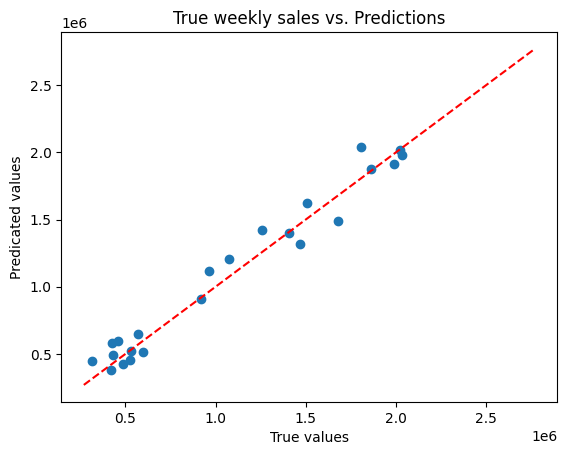

In [ ]:
# Plot the results

plt.scatter(y_test, Y_test_pred)
plt.xlabel("True values")
plt.ylabel("Predicated values")
plt.title("True weekly sales vs. Predictions")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--")


## Feature importance

In [ ]:
# 1) Build DataFrame
coefs = pd.DataFrame({
    "Feature": preprocessor.get_feature_names_out(),
    "Coefficient": regressor.coef_.ravel()
})

# 2) Sort once by absolute value, descending
feature_importance = coefs.reindex(
    coefs["Coefficient"].abs().sort_values(ascending=False).index
)

display(feature_importance)

,Feature,Coefficient
12,cat__Store_5.0,-1.338348e+06
16,cat__Store_9.0,-1.168988e+06
10,cat__Store_3.0,-1.161196e+06
22,cat__Store_16.0,-1.081720e+06
14,cat__Store_7.0,-8.930977e+05
15,cat__Store_8.0,-7.155046e+05
20,cat__Store_14.0,6.960740e+05
23,cat__Store_17.0,-6.910919e+05
17,cat__Store_10.0,6.644749e+05
11,cat__Store_4.0,6.406400e+05


In [ ]:
# 4) Plot in the same order
fig = px.bar(feature_importance,
             x="Coefficient", y="Feature",
             orientation="h",
             title="Baseline Linear Regression - Feature Importance",
             height=1000)
fig.update_layout(showlegend=False,
                  margin={'l': 180},
                  yaxis=dict(autorange="reversed"))  # biggest at top
fig.show()

**Key insights:**
- The feature importance outputs from the linear regression model suggests that:

-> Store identity is a strong predictor of weekly sales (location/size effects)

-> Seasonality matters: quarter and month cyclical features carry some predictive signal, capturing holiday/seasonal sales patterns

-> Interestingly, once we control for these, the Holiday flag shows a small negative effect — suggesting that the holiday-sales boost seen in raw data is largely explained by seasonal patterns and store effects rather than the holiday flag alone.

-> Macroeconomic factors: CPI,  unemployment, and fuel price also contribute, but their coefficients are smaller than store or calendar effects.


# Part 4. Regularization and Hyperparameter Optimization

## Ridge

In [ ]:
from sklearn.linear_model import RidgeCV # Ridge regression with built-in cross-validation to find the best alpha

# Define a range of alpha values (from 1e-4 to 1e2) on a log scale
alphas = np.logspace(-4, 2, 100) # Alpha controls the regularization strength (higher = more penalty)
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train, y_train)

print("Best alpha:", ridge_cv.alpha_)
print("Train R2:", ridge_cv.score(X_train, y_train))
print("Test R2:", ridge_cv.score(X_test, y_test))


Best alpha: 0.093260334688322
Train R2: 0.9714564751569701
Test R2: 0.9657666269675491


In [ ]:
# Train the regularized model and compute the accuracy score on the training and test sets
regressor = Ridge(alpha=ridge_cv.alpha_)

ridge_model = regressor.fit(X_train, y_train)

Y_train_pred = ridge_model.predict(X_train)
Y_test_pred = ridge_model.predict(X_test)

# R² Scores
r2_train = r2_score(y_train, Y_train_pred)
r2_test = r2_score(y_test, Y_test_pred)
r2_gap = r2_train - r2_test

# Print scores
print("R2 score on training set : ", r2_train)
print("R2 score on test set : ", r2_test)
print("Overfitting gap (train - test) : ", r2_gap)
print("")

# Cross-validation
scores_train = cross_val_score(ridge_model, X_train, y_train, cv=4)
scores_test = cross_val_score(ridge_model, X_test, y_test, cv=4)
print("Cross-validated score on training set : ", scores_train.mean())
print("Standard deviation (train CV scores): ", scores_train.std())


R2 score on training set :  0.9714564751569701
R2 score on test set :  0.9657666269675491
Overfitting gap (train - test) :  0.005689848189420976

Cross-validated score on training set :  0.8962520799514798
Standard deviation (train CV scores):  0.02673677443162864


## Lasso

In [ ]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(cv=5).fit(X_train, y_train)
print("Best alpha:", lasso.alpha_)

Best alpha: 1207.7360045779558


In [ ]:
# Train the regularized model and compute the accuracy score on the training and test sets
regressor = Lasso(alpha=lasso.alpha_)

lasso_model = regressor.fit(X_train, y_train)

Y_train_pred = lasso_model.predict(X_train)
Y_test_pred = lasso_model.predict(X_test)

# R² Scores
r2_train = r2_score(y_train, Y_train_pred)
r2_test = r2_score(y_test, Y_test_pred)
r2_gap = r2_train - r2_test

# Print scores
print("R2 score on training set : ", r2_train)
print("R2 score on test set : ", r2_test)
print("Overfitting gap (train - test) : ", r2_gap)
print("")

# Cross-validation
scores_train = cross_val_score(lasso_model, X_train, y_train, cv=4)
scores_test = cross_val_score(lasso_model, X_test, y_test, cv=4)
print("Cross-validated score on training set : ", scores_train.mean())
print("Standard deviation (train CV scores): ", scores_train.std())


R2 score on training set :  0.9698919048672442
R2 score on test set :  0.962186748976974
Overfitting gap (train - test) :  0.00770515589027021

Cross-validated score on training set :  0.8995503718262304
Standard deviation (train CV scores):  0.028502389639920588


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.563e+10, tolerance: 7.544e+08



# Part 5. Models Comparison

## Models Performance

In [ ]:
results = []

def evaluate_model(name, model, X_train, y_train, X_test, y_test, cv=4):
    # Fit
    model.fit(X_train, y_train)

    # Predictions
    ytr = model.predict(X_train)
    yte = model.predict(X_test)

    # Metrics
    r2_train = r2_score(y_train, ytr)
    r2_test  = r2_score(y_test, yte)
    row = {
        "model": name,
        "r2_train": r2_train,
        "r2_test": r2_test,
        "overfit_gap": r2_train - r2_test,
    }

    # Cross-validation
    if cv:
        scores = cross_val_score(model, X_train, y_train, cv=cv)
        row["cv_mean_r2"] = scores.mean()
        row["cv_std"]  = scores.std()

    results.append(row)


In [ ]:
# Linear Regression
evaluate_model("Linear Regression", LinearRegression(), X_train, y_train, X_test, y_test)

# Ridge
evaluate_model("Ridge", Ridge(alpha=ridge_cv.alpha_, random_state=42), X_train, y_train, X_test, y_test)

# Lasso
evaluate_model("Lasso", Lasso(alpha=lasso.alpha_, random_state=42, max_iter=5000), X_train, y_train, X_test, y_test)

# Collect results in DataFrame
results_df = pd.DataFrame(results)
display(results_df)

,model,r2_train,r2_test,overfit_gap,cv_mean_r2,cv_std
0,Linear Regression,0.972821,0.964887,0.007934,0.894210,0.037258
1,Ridge,0.971456,0.965767,0.005690,0.896252,0.026737
2,Lasso,0.969892,0.962187,0.007705,0.899550,0.028502


### **Conclusion**

- All three models perform very well, with high R2 on both train and test sets.
- Linear Regression shows the highest overfitting gap.
- Both Ridge and Lasso reduce overfitting slightly, as shown by the smaller gap between training and test R2.
- Ridge performs slightly better overall (on the test set) with the smallest overfitting gap, higher CV score than baseline and lowest standard deviation (most stable across folds)

-> This demonstrates that regularization improves model generalization, even in well-behaved datasets.

-> Despite introducing additional complexity via features engineering and noise, the model continued to demonstrate strong generalization.

--> This suggests that the underlying features provide a high signal-to-noise ratio and capture a significant portion of the variance in the target variable.
As a result, even a simple linear model is able to learn the key patterns without heavily overfitting.

--> Regularization techniques like Ridge and Lasso improved model robustness by slightly reducing the overfitting and stabilizing cross-valisation performance.



## Feature Importance

In [ ]:
feature_names = preprocessor.get_feature_names_out()

coef_comparison = pd.DataFrame({
    "Feature": feature_names,
    "Linear": np.ravel(model.coef_),
    "Ridge":  np.ravel(ridge_model.coef_),
    "Lasso":  np.ravel(lasso_model.coef_),
})

coef_long = coef_comparison.melt(
    id_vars="Feature", var_name="Model", value_name="Coefficient"
)

# Order features by strongest absolute effect seen in any model
feature_order = (coef_long.groupby("Feature")["Coefficient"]
                 .apply(lambda s: s.abs().max())
                 .sort_values(ascending=True).index.tolist())

fig = px.bar(
    coef_long,
    x="Coefficient", y="Feature",
    color="Model",
    orientation="h",
    category_orders={"Feature": feature_order},
    title="Feature Importance Comparison — Baseline Linear Regression vs Ridge vs Lasso",
)

fig.update_layout(
    barmode="group",
    yaxis=dict(autorange="reversed"),   # biggest at top
    margin={'l': 200},
    template="plotly_white",
    height=min(1200, 30*len(feature_order) + 200)  # auto-size sensibly
)
fig.show()



**Key insights:**

- Store effects dominate: Several specific stores (e.g., Store 5, 9, 3, 16, 14, 10) have the largest positive or negative coefficients across all models, confirming that store identity is the strongest driver of weekly sales variation.

- Consistency across models: Ridge and Linear give very similar magnitudes, while Lasso shrinks some coefficients slightly (e.g., Store 15, Holiday_Flag, Quarter), reflecting its built-in feature selection effect.

- Holiday impact: The Holiday_Flag variable has a negative coefficient across models, suggesting that sales decrease on holidays compared to regular days (after controlling for store effects and seasonality).

- Numeric features matter less: Macroeconomic (CPI, Fuel Price, Unemployment) and time-based (Quarter, Month/Day sin–cos) variables have much smaller coefficients compared to store dummies, meaning they explain less variance relative to store identity.


-> Store identity dominates sales prediction, but Ridge/Lasso help regulate and slightly adjust the importance of weaker predictors.